<a href="https://colab.research.google.com/github/riyagoyal17/AI-Mafia-Machine-Learning/blob/main/3_hidden_images_using_ssim_metrics_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [54]:
!unzip gdrive/My\ Drive/data/smalldata1.zip

Streaming output truncated to the last 5000 lines.
  inflating: smalldata1/tacos/101.png  
  inflating: smalldata1/tacos/102.png  
  inflating: smalldata1/tacos/103.png  
  inflating: smalldata1/tacos/104.png  
  inflating: smalldata1/tacos/105.png  
  inflating: smalldata1/tacos/106.png  
  inflating: smalldata1/tacos/107.png  
  inflating: smalldata1/tacos/108.png  
  inflating: smalldata1/tacos/109.png  
  inflating: smalldata1/tacos/11.png  
  inflating: smalldata1/tacos/110.png  
  inflating: smalldata1/tacos/111.png  
  inflating: smalldata1/tacos/112.png  
  inflating: smalldata1/tacos/113.png  
  inflating: smalldata1/tacos/114.png  
  inflating: smalldata1/tacos/115.png  
  inflating: smalldata1/tacos/116.png  
  inflating: smalldata1/tacos/117.png  
  inflating: smalldata1/tacos/118.png  
  inflating: smalldata1/tacos/119.png  
  inflating: smalldata1/tacos/12.png  
  inflating: smalldata1/tacos/120.png  
  inflating: smalldata1/tacos/121.png  
  inflating: smalldata1/tacos/1

In [55]:
!pip install SSIM-PIL

In [56]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
#from keras.engine.topology import Container
from keras.engine.network import Network
from keras.layers import *
from keras import backend
from keras.models import Model,load_model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import random
import scipy.misc
from tqdm import *
from SSIM_PIL import compare_ssim
from PIL import Image
from google.colab import files


In [57]:
#DATA_DIR = "./data"
TRAIN_DIR = "/content/smalldata1"
#TEST_DIR = os.path.join(DATA_DIR, "test")
#print(os.listdir(TRAIN_DIR))
IMG_SHAPE = (64, 64)

def load_dataset_small(num_images_per_class_train=20, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """

    X_train = []
    X_test = []
    
    # Create training set.
    #print(os.listdir(TRAIN_DIR))
    
    for c in os.listdir("/content/smalldata1"):
        #print(c)
        c_dir = os.path.join("/content/smalldata1",c)
        c_imgs = os.listdir(c_dir)
        #print(c_imgs," ")
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            #print(img_name_i)
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            #img_i = np.asarray(img_i).reshape(64,64)

           # print(img_i.size[0] , img_i.size[1])
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
  
    # Return train and test data as numpy arr
    return np.array(X_train)

In [58]:
# Load dataset.
X_train_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 2020
Number of test examples = 2020
X_train shape: (2020, 64, 64, 3)


In [59]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S1: secret image1
input_S1 = X_train[0:X_train.shape[0] // 4]
# S2: secret image2
input_S2 = X_train[X_train.shape[0] // 4 : 2*(X_train.shape[0] // 4)]
# S3: secret image3
input_S3 = X_train[2*(X_train.shape[0] // 4) : 3*(X_train.shape[0] // 4)]

# C: cover image
input_C = X_train[3*(X_train.shape[0] // 4):]

Sample Images from Loaded Data

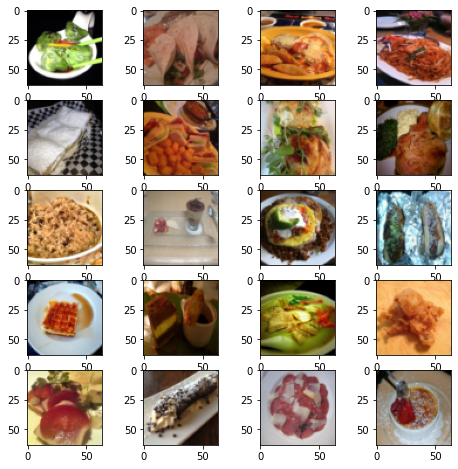

In [60]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

# **Model**

The model is composed of three parts: The Preparation Network, Hiding Network (Encoder) and the Reveal Network. Its goal is to be able to encode information about the secret image S into the cover image C, generating C' that closely resembles C, while still being able to decode information from C' to generate the decoded secret image S', which should resemble S as closely as possible.

The Preparation Network has the responsibility of preparing data from the secret image to be concatenated with the cover image and fed to the Hiding Network. The Hiding Network than transforms that input into the encoded cover image C'. Finally, the Reveal Network decodes the secret image S' from C'. For stability, we add noise before the Reveal Network, as suggested by the paper. Although the author of the paper didn't originally specify the architecture of the three networks, we discovered aggregated layers showed good results. For both the Hiding and Reveal networks, we use 5 layers of 65 filters (50 3x3 filters, 10 4x4 filters and 5 5x5 filters). For the preparation network, we use only 2 layers with the same structure.

Note that the loss function for the Reveal Network is different from the loss function for the Preparation and Hiding Networks. In order to correctly implement the updates for the weights in the networks, we create stacked Keras models, one for the Preparation and Hiding Network (which share the same loss function) and one for the Reveal Network. To make sure weights are updated only once, we freeze the weights on the layers of the Reveal Network before adding it to the full model.

# Define Loss
Mean Square Loss has been used. Loss for reveal network and the full network are different.

In [61]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s1_true, s2_true, s3_true, c_true = y_true[...,0:3], y_true[...,3:6], y_true[...,6:9], y_true[...,9:12]
    s1_pred, s2_pred, s3_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6], y_pred[...,6:9], y_pred[...,9:12]

    s1_loss = beta * K.sum(K.square(s1_true - s1_pred))
    s2_loss = beta * K.sum(K.square(s2_true - s2_pred))
    s3_loss = beta * K.sum(K.square(s3_true - s3_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s1_loss + c_loss + s2_loss + s3_loss

def ssim_loss(y_true, y_pred):
  return  tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

def ssim_l2_loss(y_true,y_pred):
  return 1-(tf.reduce_mean(tf.image.ssim(y_true,y_pred,2.0)))#+ beta*(K.sum(K.square(y_true - y_pred)))

def full_ssim_l2_loss(y_true,y_pred):

  s_true, c_true = y_true[...,0:3], y_true[...,3:6]
  s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]

  #s_loss = rev_loss(s_true, s_pred)
  s_loss =  1 - (tf.reduce_mean(tf.image.ssim(s_true,s_pred,2.0))) #+ beta*(K.sum(K.square(s_true - s_pred)))
  c_loss =  1 - (tf.reduce_mean(tf.image.ssim(c_true,c_pred,2.0))) #+ (K.sum(K.square(c_true - c_pred)))

  return s_loss + c_loss

# Define Encoder
It has Prep and Hiding Network.

In [62]:
# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S1 = Input(shape=(input_size))
    input_S2 = Input(shape=(input_size))
    input_S3 = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network for Secret Image 2
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_1')(input_S1)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_1')(input_S1)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_1')(input_S1)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_1')(x)
    x1 = concatenate([x3, x4, x5])

    # Preparation Network for Secret Image 2
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_2')(input_S2)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_2')(input_S2)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_2')(input_S2)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_2')(x)
    x2 = concatenate([x3, x4, x5])

    # Preparation Network for Secret Image 3
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_3')(input_S3)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_3')(input_S3)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_3')(input_S3)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_3')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_3')(x)
    x3_1 = concatenate([x3, x4, x5])
    
    # Prep Network outputs concatenated to the encoded cover
    x = concatenate([input_C, x1, x2, x3_1])
    
    # Hiding network 
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S1, input_S2, input_S3, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Define all decoders.
Currently 3 decoders for 3 secret image retrieval.

In [63]:
# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder1(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise1')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3_1')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4_1')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5_1')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    output_S1prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S1')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S1prime)
    else:
        return Network(inputs=reveal_input,
                         outputs=output_S1prime)
        
# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder2(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise2')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3_2')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4_2')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5_2')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    output_S2prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S2')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S2prime)
    else:
        return Network(inputs=reveal_input,
                         outputs=output_S2prime)

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder3(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise2')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_S3prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S3')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S3prime)
    else:
        """return Container(inputs=reveal_input,
                         outputs=output_S2prime,
                         name = 'DecoderFixed')"""
        return Network(inputs=reveal_input,
                         outputs=output_S3prime)

# Define Full Model.
Assemble the encoders and decoders

In [64]:
# Full model.
def make_model(input_size):
    input_S1 = Input(shape=(input_size))
    input_S2 = Input(shape=(input_size))
    input_S3 = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder1 = make_decoder1(input_size)
    decoder1.compile(optimizer='adam', loss=rev_loss,metrics = ssim_loss)
    decoder1.trainable = False

    decoder2 = make_decoder2(input_size)
    decoder2.compile(optimizer='adam', loss=rev_loss,metrics = ssim_loss)
    decoder2.trainable = False

    decoder3 = make_decoder3(input_size)
    decoder3.compile(optimizer='adam', loss=rev_loss,metrics = ssim_loss)
    decoder3.trainable = False
    
    output_Cprime = encoder([input_S1, input_S2, input_S3, input_C])
    output_S1prime = decoder1(output_Cprime)
    output_S2prime = decoder2(output_Cprime)
    output_S3prime = decoder3(output_Cprime)

    autoencoder1 = Model(inputs=[input_S1, input_S2, input_S3, input_C],
                        outputs=concatenate([output_S1prime, output_S2prime, output_S3prime, output_Cprime]))
    autoencoder1.compile(optimizer='adam', loss=full_loss,metrics = ssim_loss)
    
    # autoencoder2 = Model(inputs=[input_S1, input_S2, input_C],
    #                     outputs=concatenate([output_S2prime, output_Cprime]))
    # autoencoder2.compile(optimizer='adam', loss=full_loss)


    return encoder, decoder1, decoder2, decoder3, autoencoder1

In [72]:
encoder_model, reveal_model1, reveal_model2, reveal_model3, autoencoder_model = make_model(input_S1.shape[1:])

# **Training**


Although the author of the paper didn't explicitly described the learning rate schedule or the optimizer properties, we used our own schedule with ADAM optimizer. We train for 1000 epochs with a batch size of 32.

In [70]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [71]:
NB_EPOCHS = 2
BATCH_SIZE = 256

m = input_S1.shape[0]
loss_history = []
rev1_history = []
rev2_history = []
rev3_history = []
#loss_history2 = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S1)
    np.random.shuffle(input_S2)
    np.random.shuffle(input_S3)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    #ae_loss2 = []
    rev_loss1 = []
    rev_loss2 = []
    rev_loss3 = []
    for idx in t:
        
        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]
        batch_S2 = input_S2[idx:min(idx + BATCH_SIZE, m)]
        batch_S3 = input_S3[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S1, batch_S2, batch_S3, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S1, batch_S2, batch_S3, batch_C],
                                                   y=np.concatenate((batch_S1, batch_S2, batch_S3, batch_C),axis=3)))
        #ae_loss2.append(autoencoder_model2.train_on_batch(x=[batch_S1, batch_S2, batch_C],
        #                                           y=np.concatenate((batch_S2, batch_C),axis=3)))
        rev_loss1.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_S1))
        rev_loss2.append(reveal_model2.train_on_batch(x=C_prime,
                                              y=batch_S2))
        rev_loss3.append(reveal_model3.train_on_batch(x=C_prime,
                                              y=batch_S3))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        #K.set_value(autoencoder_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model3.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev1 {:10.2f} | Loss Rev2 {:10.2f} | Loss Rev3 {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1), np.mean(rev_loss2), np.mean(rev_loss3)))
    
    #autoencoder_model.save_weights('models/model3_'+str(epoch))
    #autoencoder_model2.save_weights('models/model'+str(epoch))
    
    loss_history.append(np.mean(ae_loss))
    rev1_history.append(np.mean(rev_loss1))
    rev2_history.append(np.mean(rev_loss2))
    rev3_history.append(np.mean(rev_loss3))
    #loss_history2.append(np.mean(ae_loss2))



  0%|          | 0/2 [00:00<?, ?it/s]

ResourceExhaustedError: ignored

In [ ]:
# Plot loss through epochs
plt.plot(loss_history,label = 'overall loss')
plt.plot(rev1_history,label = 'rev1 loss')
plt.plot(rev2_history,label = 'rev2_loss')
plt.plot(rev3_history,label = 'rev3_loss')
plt.title('Model loss, reveal images loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig("loss_1000_metrics_ssim.png")
files.download("loss_1000_metrics_ssim.png") 
plt.show()
#plt.show()

In [ ]:
for epoch in range(5):
    np.random.shuffle(input_S1)
    np.random.shuffle(input_S2)
    np.random.shuffle(input_S3)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss1 = []
    rev_loss2 = []
    rev_loss3 = []
    for idx in t:
        
        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]
        batch_S2 = input_S2[idx:min(idx + BATCH_SIZE, m)]
        batch_S3 = input_S3[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S1, batch_S2, batch_S3, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S1, batch_S2, batch_S3, batch_C],
                                                   y=np.concatenate((batch_S1, batch_S2, batch_S3, batch_C),axis=3)))
        rev_loss1.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_S1))
        rev_loss2.append(reveal_model2.train_on_batch(x=C_prime,
                                              y=batch_S2))
        rev_loss3.append(reveal_model3.train_on_batch(x=C_prime,
                                              y=batch_S3))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model3.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev1 {:10.2f} | Loss Rev2 {:10.2f} | Loss Rev3 {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1), np.mean(rev_loss2), np.mean(rev_loss3)))
    
    #autoencoder_model.save_weights('models/model3_'+str(epoch+6))
    
    loss_history.append(np.mean(ae_loss))
    rev1_history.append(np.mean(rev_loss1))
    rev2_history.append(np.mean(rev_loss2))
    rev3_history.append(np.mean(rev_loss3))


  0%|          | 0/2 [00:00<?, ?it/s]

ResourceExhaustedError: ignored

In [ ]:
for epoch in range(50):
    np.random.shuffle(input_S1)
    np.random.shuffle(input_S2)
    np.random.shuffle(input_S3)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss1 = []
    rev_loss2 = []
    rev_loss3 = []
    for idx in t:
        
        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]
        batch_S2 = input_S2[idx:min(idx + BATCH_SIZE, m)]
        batch_S3 = input_S3[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S1, batch_S2, batch_S3, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S1, batch_S2, batch_S3, batch_C],
                                                   y=np.concatenate((batch_S1, batch_S2, batch_S3, batch_C),axis=3)))
        rev_loss1.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_S1))
        rev_loss2.append(reveal_model2.train_on_batch(x=C_prime,
                                              y=batch_S2))
        rev_loss3.append(reveal_model3.train_on_batch(x=C_prime,
                                              y=batch_S3))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model3.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev1 {:10.2f} | Loss Rev2 {:10.2f} | Loss Rev3 {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1), np.mean(rev_loss2), np.mean(rev_loss3)))
    
    #autoencoder_model.save_weights('models/model3_'+str(epoch+6))
    
    loss_history.append(np.mean(ae_loss))
    rev1_history.append(np.mean(rev_loss1))
    rev2_history.append(np.mean(rev_loss2))
    rev3_history.append(np.mean(rev_loss3))

In [ ]:
# Plot loss through epochs
plt.plot(loss_history,label = 'overall loss')
plt.plot(rev1_history,label = 'rev1 loss')
plt.plot(rev2_history,label = 'rev2_loss')
plt.plot(rev3_history,label = 'rev3_loss')
plt.title('Model loss, reveal images loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig("loss_400_sse.png")
files.download("loss_400_ssem.png") 
plt.show()
#plt.show()

In [ ]:
for epoch in range(700):
    np.random.shuffle(input_S1)
    np.random.shuffle(input_S2)
    np.random.shuffle(input_S3)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss1 = []
    rev_loss2 = []
    rev_loss3 = []
    for idx in t:
        
        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]
        batch_S2 = input_S2[idx:min(idx + BATCH_SIZE, m)]
        batch_S3 = input_S3[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S1, batch_S2, batch_S3, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S1, batch_S2, batch_S3, batch_C],
                                                   y=np.concatenate((batch_S1, batch_S2, batch_S3, batch_C),axis=3)))
        rev_loss1.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_S1))
        rev_loss2.append(reveal_model2.train_on_batch(x=C_prime,
                                              y=batch_S2))
        rev_loss3.append(reveal_model3.train_on_batch(x=C_prime,
                                              y=batch_S3))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model3.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev1 {:10.2f} | Loss Rev2 {:10.2f} | Loss Rev3 {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1), np.mean(rev_loss2), np.mean(rev_loss3)))
    
    #autoencoder_model.save_weights('models/model3_'+str(epoch+6))
    
    loss_history.append(np.mean(ae_loss))
    rev1_history.append(np.mean(rev_loss1))
    rev2_history.append(np.mean(rev_loss2))
    rev3_history.append(np.mean(rev_loss3))

In [ ]:
# Plot loss through epochs
plt.plot(loss_history,label = 'overall loss')
plt.plot(rev1_history,label = 'rev1 loss')
plt.plot(rev2_history,label = 'rev2_loss')
plt.plot(rev3_history,label = 'rev3_loss')
plt.title('Model loss, reveal images loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig("loss_1000_metrics_ssim.png")
files.download("loss_1000_metrics_ssim.png") 
plt.show()
#plt.show()

In [73]:
BATCH_SIZE = 32
loss_history = []
rev1_history = []
rev2_history = []
rev3_history = []
m = input_S1.shape[0]
for epoch in range(400):
    np.random.shuffle(input_S1)
    np.random.shuffle(input_S2)
    np.random.shuffle(input_S3)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss1 = []
    rev_loss2 = []
    rev_loss3 = []
    for idx in t:
        
        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]
        batch_S2 = input_S2[idx:min(idx + BATCH_SIZE, m)]
        batch_S3 = input_S3[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S1, batch_S2, batch_S3, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S1, batch_S2, batch_S3, batch_C],
                                                   y=np.concatenate((batch_S1, batch_S2, batch_S3, batch_C),axis=3)))
        rev_loss1.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_S1))
        rev_loss2.append(reveal_model2.train_on_batch(x=C_prime,
                                              y=batch_S2))
        rev_loss3.append(reveal_model3.train_on_batch(x=C_prime,
                                              y=batch_S3))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model3.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f} | Loss Rev2 {:10.2f} | Loss Rev3 {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1), np.mean(rev_loss2), np.mean(rev_loss3)))
    
    autoencoder_model.save_weights('models/model_A21_'+str(epoch))
    
    loss_history.append(np.mean(ae_loss))
    rev1_history.append(np.mean(rev_loss1))
    rev2_history.append(np.mean(rev_loss2))
    rev3_history.append(np.mean(rev_loss3))




  0%|          | 0/16 [00:00<?, ?it/s]




Epoch 1 | Batch:   0 of 505. Loss AE  219346.68 | Loss Rev   53078.63 | Loss Rev2   54710.58 | Loss Rev3   55512.41:   0%|          | 0/16 [00:07<?, ?it/s]


Epoch 1 | Batch:   0 of 505. Loss AE  219346.68 | Loss Rev   53078.63 | Loss Rev2   54710.58 | Loss Rev3   55512.41:   6%|▋         | 1/16 [00:07<01:57,  7.83s/it]


Epoch 1 | Batch:  32 of 505. Loss AE  300789.44 | Loss Rev   42275.16 | Loss Rev2   82889.79 | Loss Rev3   90523.67:   6%|▋         | 1/16 [00:08<01:57,  7.83s/it]


Epoch 1 | Batch:  32 of 505. Loss AE  300789.44 | Loss Rev   42275.16 | Loss Rev2   82889.79 | Loss Rev3   90523.67:  12%|█▎        | 2/16 [00:08<01:20,  5.79s/it]


Epoch 1 | Batch:  64 of 505. Loss AE  266309.24 | Loss Rev   45176.28 | Loss Rev2   71486.59 | Loss Rev3   76873.13:  12%|█▎        | 2/16 [00:09<01:20,  5.79s/it]


Epoch 1 | Batch:  64 of 505. Loss AE  266309.24 | Loss Rev   45176.28 | Loss Rev2   71486.59 | Loss Rev3   76873.13:  19%|█▉        | 3/16 [00:09<00:56,  4.35s/it]


Epoch 1 |

Streaming output truncated to the last 5000 lines.


Epoch 350 | Batch: 480 of 505. Loss AE    4262.81 | Loss Rev     651.40 | Loss Rev2     848.42 | Loss Rev3     761.01: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]



  0%|          | 0/16 [00:00<?, ?it/s]


Epoch 351 | Batch:   0 of 505. Loss AE    4266.30 | Loss Rev     622.81 | Loss Rev2     757.90 | Loss Rev3     675.05:   0%|          | 0/16 [00:01<?, ?it/s]


Epoch 351 | Batch:   0 of 505. Loss AE    4266.30 | Loss Rev     622.81 | Loss Rev2     757.90 | Loss Rev3     675.05:   6%|▋         | 1/16 [00:01<00:15,  1.02s/it]


Epoch 351 | Batch:  32 of 505. Loss AE    4420.88 | Loss Rev     618.72 | Loss Rev2     793.26 | Loss Rev3     718.83:   6%|▋         | 1/16 [00:02<00:15,  1.02s/it]


Epoch 351 | Batch:  32 of 505. Loss AE    4420.88 | Loss Rev     618.72 | Loss Rev2     793.26 | Loss Rev3     718.83:  12%|█▎        | 2/16 [00:02<00:14,  1.03s/it]


Epoch 351 | Batch:  64 of 505. Loss AE    4409.37 | Loss Rev     660.74 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

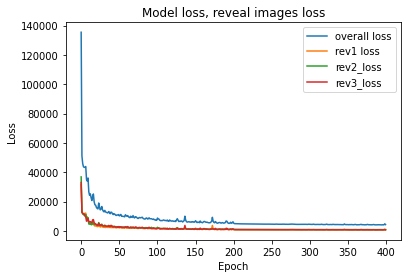

In [74]:
# Plot loss through epochs 
plt.plot(loss_history,label = 'overall loss')
plt.plot(rev1_history,label = 'rev1 loss')
plt.plot(rev2_history,label = 'rev2_loss')
plt.plot(rev3_history,label = 'rev3_loss')
plt.title('Model loss, reveal images loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig("3_hiddeen_loss_400_sse_metric_ssim.png")
files.download("3_hiddeen_loss_400_sse_metric_ssim.png") 
plt.show()
#plt.show()

In [77]:
   # Read images from file.
  #  im1 = tf.decode_png('path/to/im1.png')
   # im2 = tf.decode_png('path/to/im2.png')
    # Compute SSIM over tf.uint8 Tensors.
ssim1 = tf.image.ssim(input_S1, decoded_S1, max_val=255, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)

    # Compute SSIM over tf.float32 Tensors.
im1 = tf.image.convert_image_dtype(input_S1, tf.float32)
im2 = tf.image.convert_image_dtype(decoded_S1, tf.float32)
ssim2 = tf.image.ssim(im1, im2, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    # ssim1 and ssim2 both have type tf.float32 and are almost equal.

print("secret1")
print("ssim1  = ",ssim1)
print("ssim2 = ",ssim2)

ssim1 = tf.image.ssim(input_S2, decoded_S2, max_val=255, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)

    # Compute SSIM over tf.float32 Tensors.
im1 = tf.image.convert_image_dtype(input_S2, tf.float32)
im2 = tf.image.convert_image_dtype(decoded_S2, tf.float32)
ssim2 = tf.image.ssim(im1, im2, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    # ssim1 and ssim2 both have type tf.float32 and are almost equal.

print("secret2")
print("ssim1  = ",ssim1)
print("ssim2 = ",ssim2)

ssim1 = tf.image.ssim(input_S3, decoded_S3, max_val=255, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)

    # Compute SSIM over tf.float32 Tensors.
im1 = tf.image.convert_image_dtype(input_S3, tf.float32)
im2 = tf.image.convert_image_dtype(decoded_S3, tf.float32)
ssim2 = tf.image.ssim(im1, im2, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    # ssim1 and ssim2 both have type tf.float32 and are almost equal.

print("secret3")
print("ssim1  = ",ssim1)
print("ssim2 = ",ssim2)

secret1
ssim1  =  tf.Tensor(
[0.9998018  0.9997935  0.9997651  0.99969417 0.999646   0.99973935
 0.9998315  0.99966353 0.9995634  0.999547   0.99953574 0.9997175
 0.9998395  0.9998393  0.9996998  0.9996824  0.99968857 0.9997763
 0.99965733 0.99986714 0.9997038  0.9997832  0.9997074  0.99969023
 0.99932194 0.9998827  0.999623   0.9997956  0.9997754  0.9996243
 0.9998341  0.9990053  0.99969023 0.9996651  0.999794   0.9997611
 0.9998822  0.99976736 0.9996877  0.99983954 0.99984145 0.99981713
 0.999782   0.9997204  0.9995346  0.99977785 0.99969673 0.9998085
 0.99954623 0.99930936 0.9996457  0.99948907 0.99992704 0.99989957
 0.9996088  0.99976397 0.99992436 0.99986094 0.9997843  0.999876
 0.99985075 0.99956864 0.99984837 0.99817604 0.9996353  0.9991019
 0.99965614 0.99981815 0.99980736 0.99968    0.9997192  0.99953437
 0.99984765 0.99977255 0.999598   0.9994325  0.9996663  0.99975616
 0.9998037  0.99980146 0.99968624 0.999798   0.99989635 0.9997761
 0.99981785 0.9996743  0.99974304 0.999283

In [78]:

   # Read images from file.
  #  im1 = tf.decode_png('path/to/im1.png')
   # im2 = tf.decode_png('path/to/im2.png')
    # Compute SSIM over tf.uint8 Tensors.
ssim1 = tf.image.ssim(input_C, decoded_C, max_val=255, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)

    # Compute SSIM over tf.float32 Tensors.
im1 = tf.image.convert_image_dtype(input_C, tf.float32)
im2 = tf.image.convert_image_dtype(decoded_C, tf.float32)
ssim2 = tf.image.ssim(im1, im2, max_val=1.0, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)
    # ssim1 and ssim2 both have type tf.float32 and are almost equal.
print("cover")
print("ssim1  = ",ssim1)
print("ssim2 = ",ssim2)

cover
ssim1  =  tf.Tensor(
[0.99903685 0.9979175  0.99981636 0.99976116 0.9995778  0.9994386
 0.9992647  0.9954471  0.99930257 0.99919957 0.99949884 0.9995618
 0.9994114  0.9995837  0.99896336 0.99893975 0.99947804 0.99904746
 0.9984104  0.9987695  0.99955577 0.9988472  0.9997403  0.9994659
 0.99889976 0.9994204  0.99945873 0.9988354  0.999022   0.9996014
 0.99872035 0.999593   0.9997321  0.999804   0.99947554 0.9983554
 0.99919987 0.99942905 0.9991588  0.9987524  0.9992989  0.9992013
 0.99970174 0.9994719  0.99657315 0.99932176 0.9938939  0.99802065
 0.9952058  0.9991584  0.99918514 0.99952275 0.9993567  0.9996422
 0.9968431  0.9981157  0.99921703 0.9994474  0.9994438  0.9993873
 0.99952984 0.99875575 0.99927133 0.9958525  0.9994064  0.99738836
 0.99878234 0.9993861  0.99956703 0.9995398  0.9990933  0.996085
 0.9982993  0.9993782  0.99941087 0.99921465 0.99935406 0.99818176
 0.9998586  0.9997737  0.99899864 0.99936074 0.9991539  0.99825907
 0.99909204 0.99828625 0.9997452  0.99965125 

In [ ]:
autoencoder_model.load_weights('models/model_A21_399')

# Decode the model's output

In [75]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S1, input_S2, input_S3, input_C])
decoded_S1, decoded_S2, decoded_S3, decoded_C = decoded[...,0:3], decoded[...,3:6], decoded[...,6:9], decoded[...,9:12]

# Get absolute difference between the outputs and the expected values.
diff_S1, diff_S2, diff_S3, diff_C = np.abs(decoded_S1 - input_S1), np.abs(decoded_S2 - input_S2), np.abs(decoded_S3 - input_S3), np.abs(decoded_C - input_C) 

In [76]:
def pixel_errors(input_S1, input_S2, input_S3, input_C, decoded_S1, decoded_S2, decoded_S3, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_S1pixel = np.sqrt(np.mean(np.square(255*(input_S1 - decoded_S1))))
    see_S2pixel = np.sqrt(np.mean(np.square(255*(input_S2 - decoded_S2))))
    see_S3pixel = np.sqrt(np.mean(np.square(255*(input_S3 - decoded_S3))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_S1pixel, see_S2pixel, see_S3pixel, see_Cpixel

def pixel_histogram(diff_S1, diff_S2, diff_S3, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_S1flat = diff_S1.flatten()
    diff_S2flat = diff_S2.flatten()
    diff_S3flat = diff_S3.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(40, 20))
    a=fig.add_subplot(2,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(2,2,2)
    imgplot = plt.hist(255* diff_S1flat, 100, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image1.')
    plt.axis([0, 250, 0, 0.2])

    a=fig.add_subplot(2,2,3)
    imgplot = plt.hist(255* diff_S2flat, 100, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image2.')
    plt.axis([0, 250, 0, 0.2])

    a=fig.add_subplot(2,2,4)
    imgplot = plt.hist(255* diff_S3flat, 100,alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image3.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [79]:
# Print pixel-wise average errors in a 256 scale.
S1_error, S2_error, S3_error, C_error = pixel_errors(input_S1, input_S2, input_S3, input_C, decoded_S1, decoded_S2, decoded_S3, decoded_C)

print ("S1 error per pixel [0, 255]:", S1_error)
print ("S2 error per pixel [0, 255]:", S2_error)
print ("S3 error per pixel [0, 255]:", S3_error)
print ("C error per pixel [0, 255]:", C_error)

S1 error per pixel [0, 255]: 14.324496
S2 error per pixel [0, 255]: 15.5553255
S3 error per pixel [0, 255]: 14.177976
C error per pixel [0, 255]: 25.73727


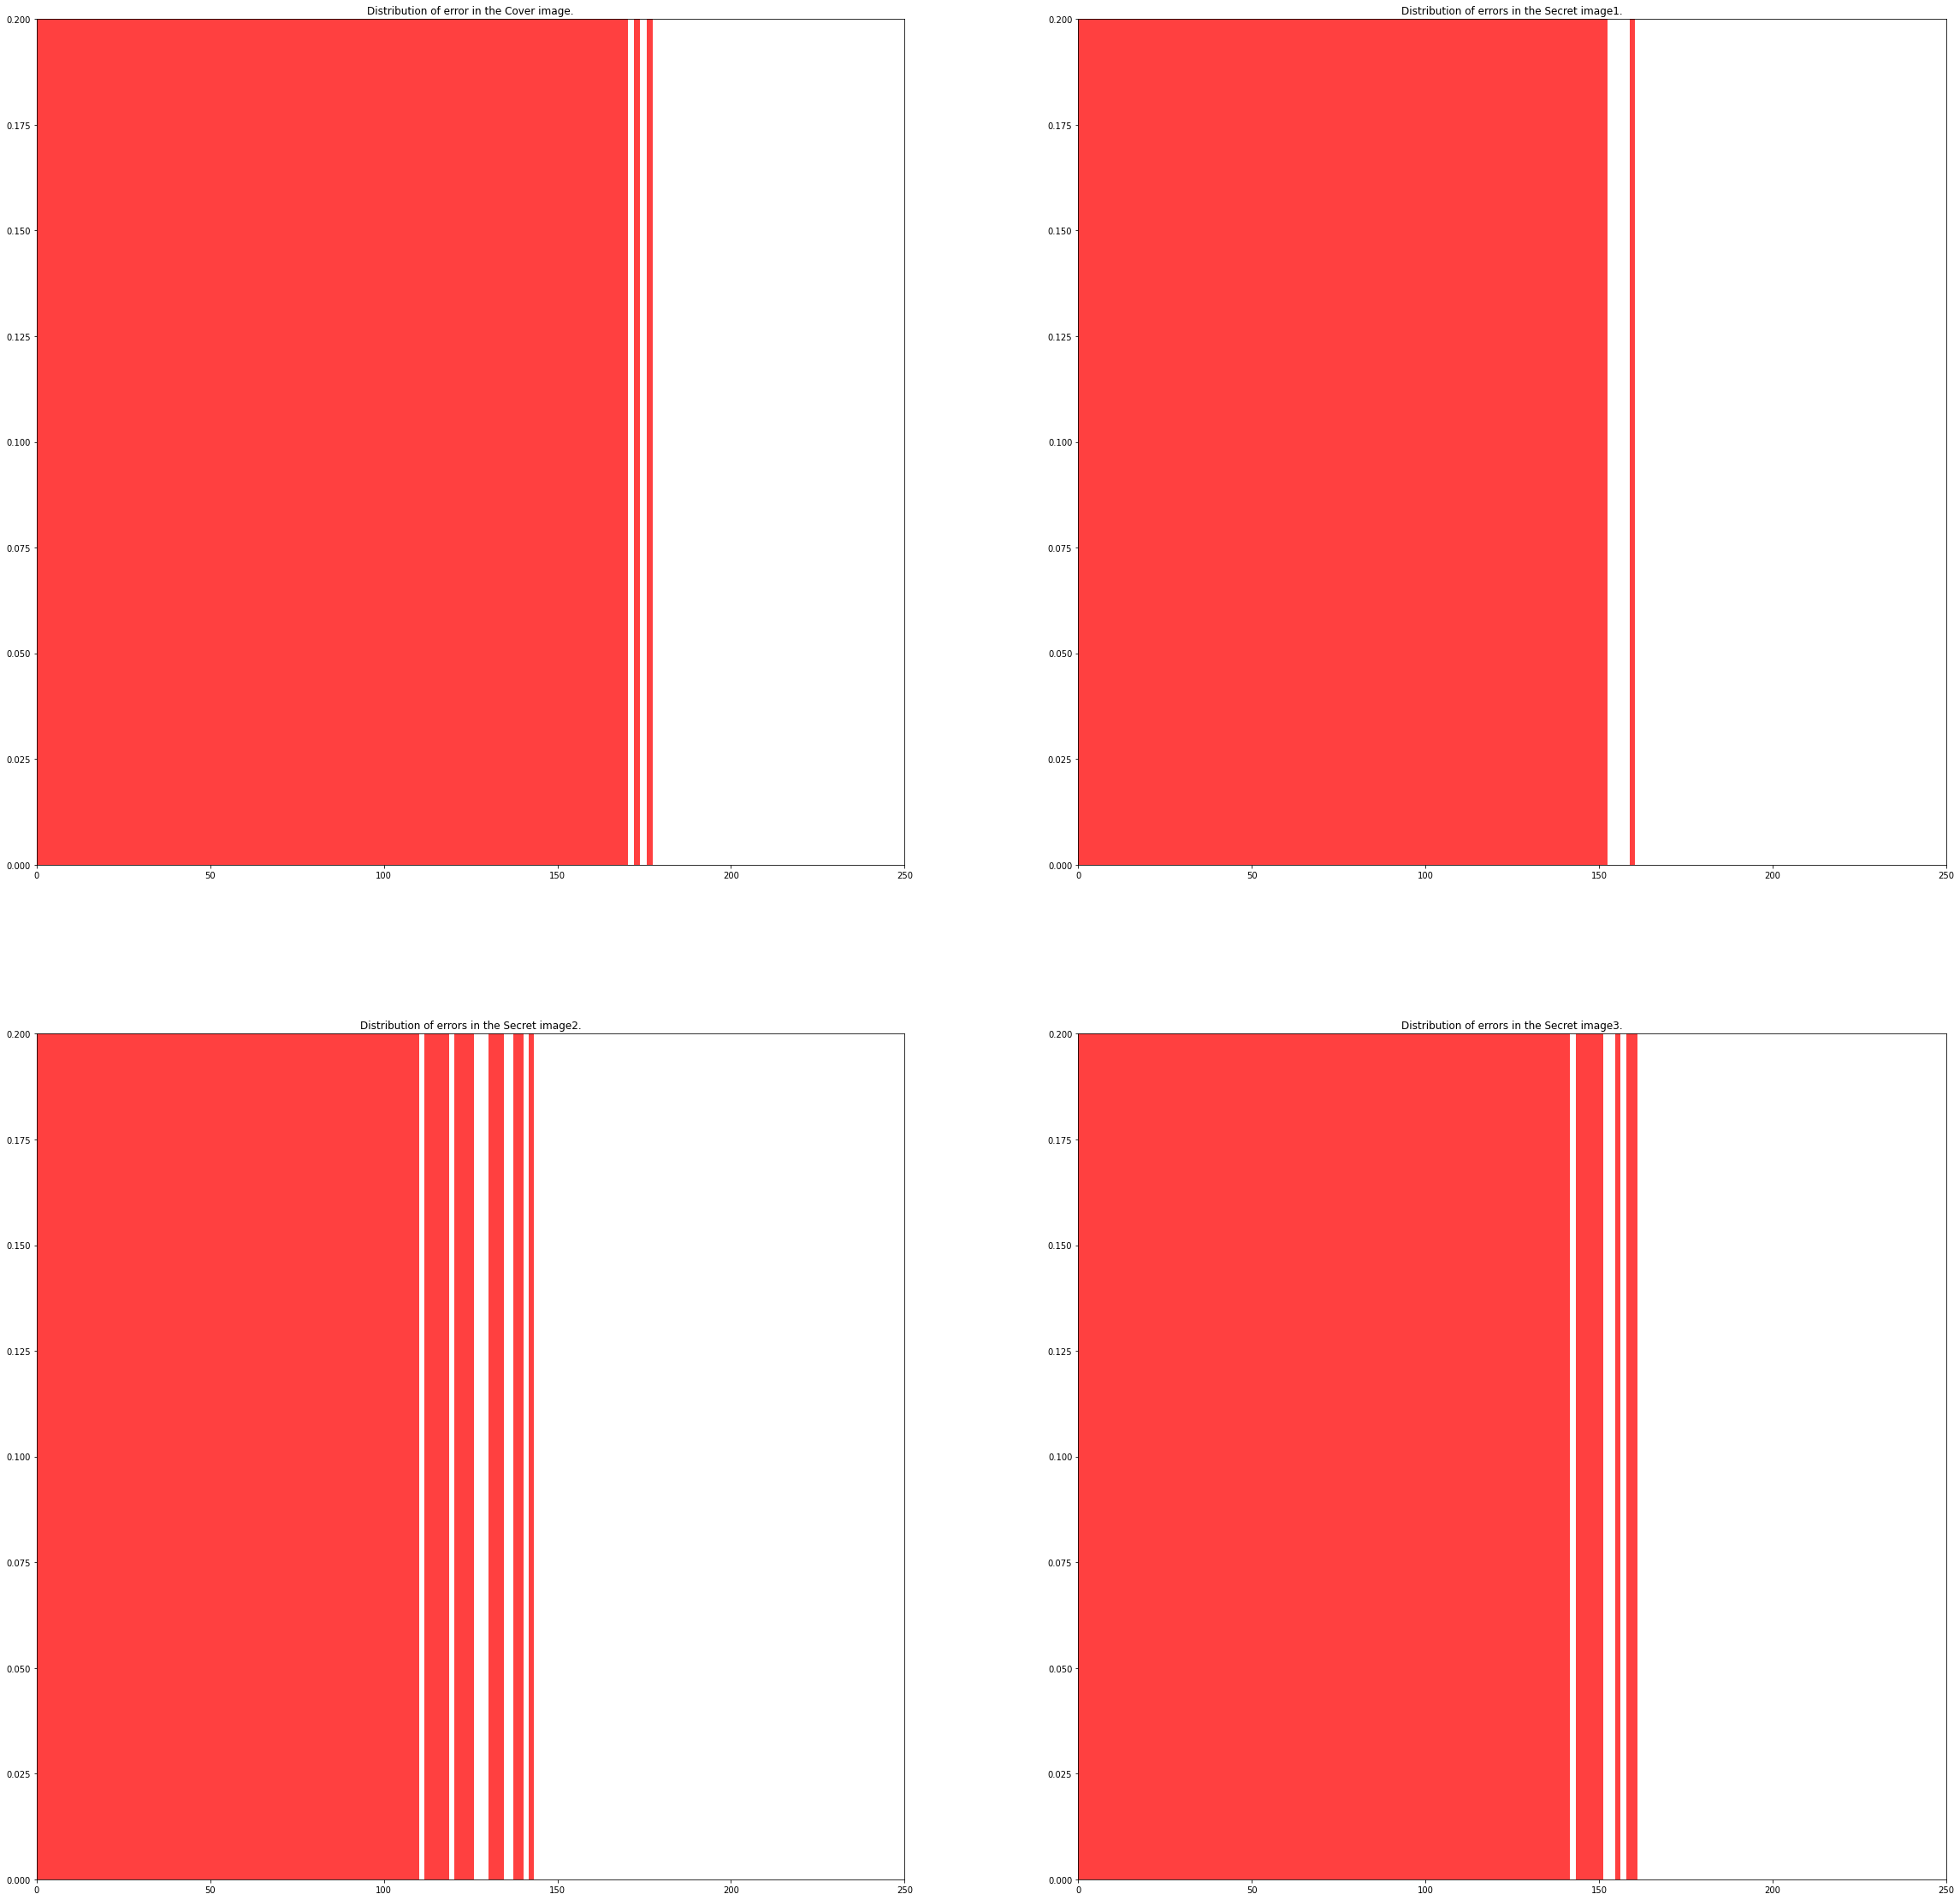

In [ ]:
# Plot distribution of errors in cover and secret images.
pixel_histogram(diff_S1, diff_S2, diff_S3, diff_C)

# Final Recovered Images. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No module named 'pyopencl'
cover :  0.6512270810007047
No module named 'pyopencl'
secret1 :  0.8531738572772304
No module named 'pyopencl'
secret2 :  0.9058741718401602
No module named 'pyopencl'
secret3 :  0.8538499501577221
No module named 'pyopencl'
cover :  0.7217601853275815
No module named 'pyopencl'
secret1 :  0.8349063947878756
No module named 'pyopencl'
secret2 :  0.8766247120166241


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No module named 'pyopencl'
secret3 :  0.8391826237680394


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No module named 'pyopencl'
cover :  0.7656489323551474
No module named 'pyopencl'
secret1 :  0.8557682085521626
No module named 'pyopencl'
secret2 :  0.9271106415618529
No module named 'pyopencl'
secret3 :  0.8466156837883466


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No module named 'pyopencl'
cover :  0.7123743964927467
No module named 'pyopencl'
secret1 :  0.7874973306964205
No module named 'pyopencl'
secret2 :  0.8846408502476766
No module named 'pyopencl'
secret3 :  0.8639760092941204
No module named 'pyopencl'
cover :  0.6065512160638606
No module named 'pyopencl'
secret1 :  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8356864533149878
No module named 'pyopencl'
secret2 :  0.8801371499108218
No module named 'pyopencl'
secret3 :  0.755964100559637
No module named 'pyopencl'
cover :  0.7389977431365257
No module named 'pyopencl'
secret1 :  0.8237154150776135
No module named 'pyopencl'
secret2 :  0.8905849038013278
No module named 'pyopencl'
secret3 :  0.8911364070807902


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

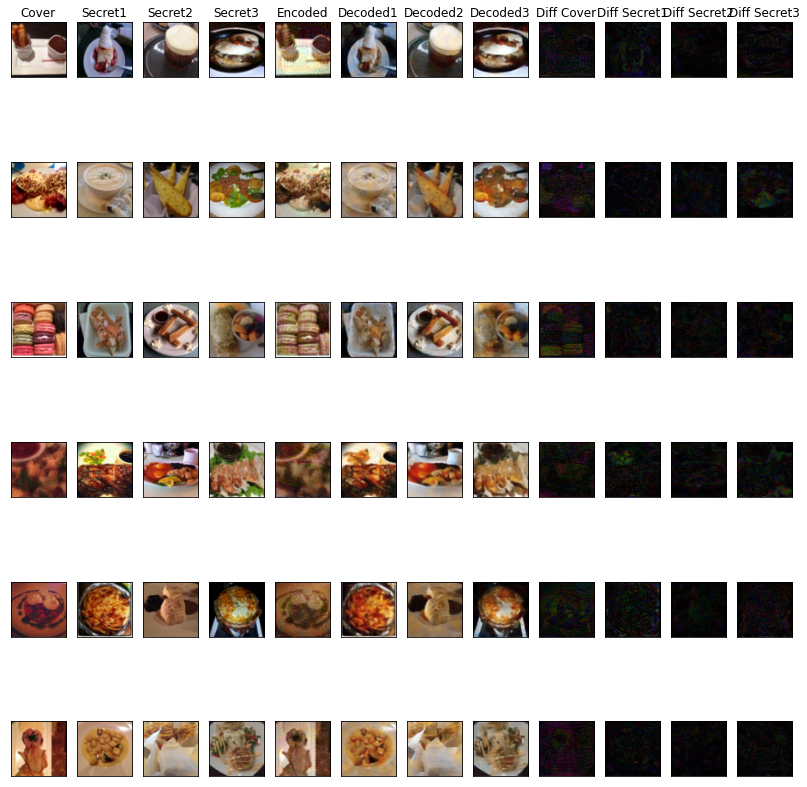

In [ ]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 500) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 12 if SHOW_DIFF else 8
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S1[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret1')

    show_image(input_S2[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Secret2')

    show_image(input_S3[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Secret3')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Encoded')
    
    show_image(decoded_S1[idx], n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Decoded1')

    show_image(decoded_S2[idx], n, n_col, i * n_col + 7, gray=SHOW_GRAY, first_row=i==0, title='Decoded2')

    show_image(decoded_S3[idx], n, n_col, i * n_col + 8, gray=SHOW_GRAY, first_row=i==0, title='Decoded3')

    
    if SHOW_DIFF:

      show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 9, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
      show_image(np.multiply(diff_S1[idx], ENHANCE), n, n_col, i * n_col + 10, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret1')

      show_image(np.multiply(diff_S2[idx], ENHANCE), n, n_col, i * n_col + 11, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret2')

      show_image(np.multiply(diff_S3[idx], ENHANCE), n, n_col, i * n_col + 12, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret3')

    cover = Image.fromarray((input_C[idx] * 255).astype(np.uint8))
    cover_decode = Image.fromarray((decoded_C[idx] * 255).astype(np.uint8))
    valuec = compare_ssim(cover,cover_decode ) # Compare images using OpenCL by default
    print("cover : ",valuec)

    secret = Image.fromarray((input_S1[idx] * 255).astype(np.uint8))
    secret_decode = Image.fromarray((decoded_S1[idx] * 255).astype(np.uint8))
    values = compare_ssim(secret,secret_decode ) # Compare images using OpenCL by default
    print("secret1 : ",values)

    secret = Image.fromarray((input_S2[idx] * 255).astype(np.uint8))
    secret_decode = Image.fromarray((decoded_S2[idx] * 255).astype(np.uint8))
    values = compare_ssim(secret,secret_decode ) # Compare images using OpenCL by default
    print("secret2 : ",values)

    secret = Image.fromarray((input_S3[idx] * 255).astype(np.uint8))
    secret_decode = Image.fromarray((decoded_S3[idx] * 255).astype(np.uint8))
    values = compare_ssim(secret,secret_decode ) # Compare images using OpenCL by default
    print("secret3 : ",values)



plt.savefig("output_3_hidden_using_metrics_ssim_loss.png")
files.download("output_3_hidden_using_metrics_ssim_loss.png") 
plt.show()

In [38]:
fixed_latent = torch.randn(1, latent_size, 1, 1, device=device)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [39]:
from torchvision.utils import save_image
from torchvision.utils import make_grid

In [40]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [41]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [42]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(0,)


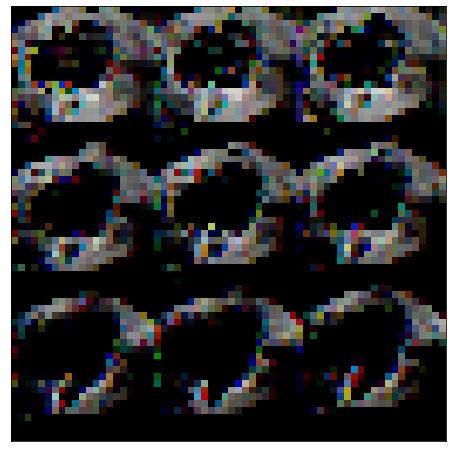

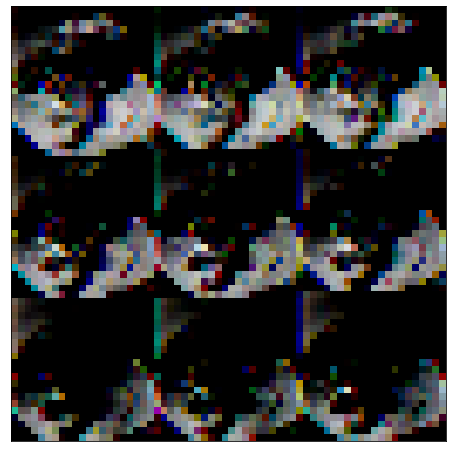

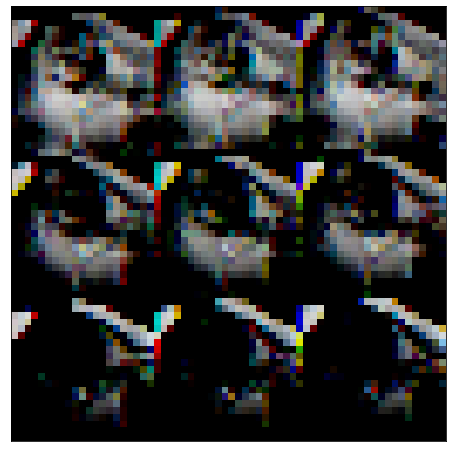

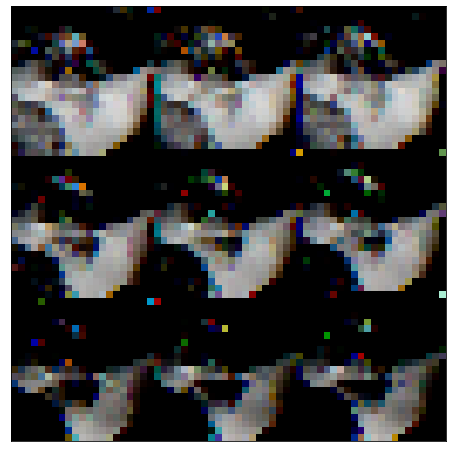

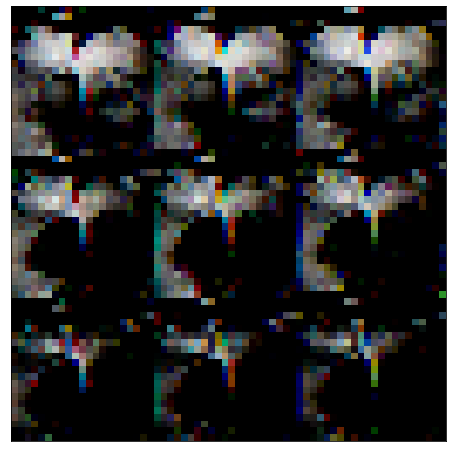

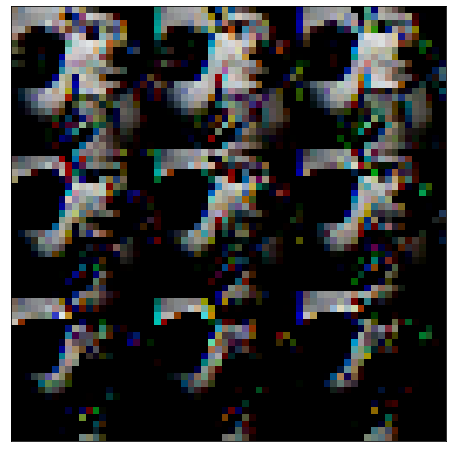

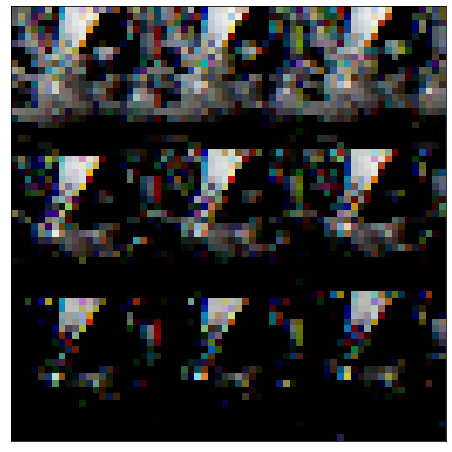

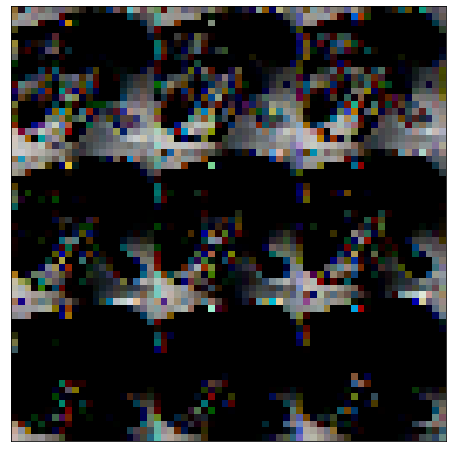

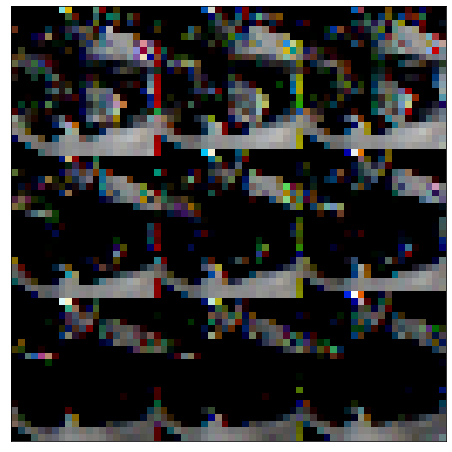

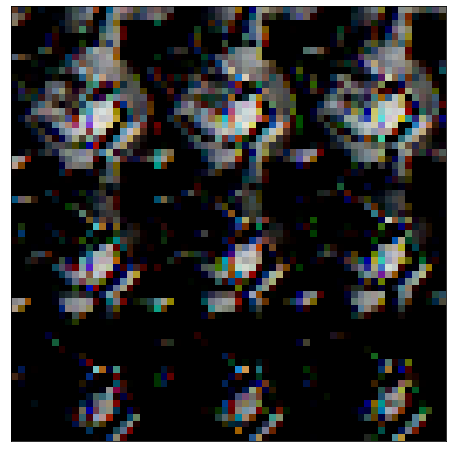

In [52]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.
import torch
import numpy as np
import matplotlib.pyplot as plt

PATH = '/content/generator_discriminator_model_60_epochs'
generator = torch.load(PATH)
# S1: secret image1
#input_S1 = X_train[0:X_train.shape[0] // 4]
input_S1 = []
latent_size = 128
batch_size = 64
device = 'cuda'

for i in range(10):

  latent = torch.randn(1, latent_size, 1, 1, device=device)
  fake_image = generator(latent)
  #save_samples(i, fixed_latent, show=True)
  #fake_image = fake_image.cpu().data.numpy().argmax()
  #fake_image = fake_image.view(fake_image.shape[3], fake_image.shape[2], fake_image.shape[1])
  #plt.imshow(fake_image.permute(3, 2, 1)  )
  #fake_image = fake_image.cpu().detach().numpy()
  #print(type(fake_image),fake_image.shape)
  #fake_image.reshape(64,64,3)
  #plt.imshow(fake_image)
  #print(type(fake_image),fake_image.shape)
  #x = image.img_to_array(fake_image)
  #input_S1.append(x)

  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  
  fake_image = fake_image.view(fake_image.shape[3], fake_image.shape[2], fake_image.shape[1])
  ax.imshow(make_grid(fake_image.cpu().detach(), nrow=8).permute(0,1,2))

  #fake_image = fake_image.cpu().detach().numpy()
  #print(type(fake_image),fake_image.shape)
  #fake_image.reshape(64,64,3)
  #plt.imshow(fake_image)
  #print(type(fake_image),fake_image.shape)
  #x = image.img_to_array(fake_image)
  #input_S1.append(x)


'''
input_S1 = np.array(input_S1)
# S2: secret image2
input_S2 = X_train[X_train.shape[0] // 4 : 2*(X_train.shape[0] // 4)]
# S3: secret image3
input_S3 = X_train[2*(X_train.shape[0] // 4) : 3*(X_train.shape[0] // 4)]

# C: cover image
input_C = X_train[3*(X_train.shape[0] // 4):]
'''

input_S1 = np.array(input_S1)
print(input_S1.shape)

In [ ]:
# Show sample images from the training dataset
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(8, 8))
columns = 1
rows = 1
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(input_S1.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(input_S1[img_idx])
plt.show()